In [451]:
import numpy as np
import libpysal as ps 
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import geopandas as gp
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import shapely
import json
import numpy as np
import contextily
import statsmodels.api as sm
import seaborn as sns

In [23]:
smelly_df = pd.read_csv('./data/smc.csv')
census_block_df = pd.read_csv('./data/Maine_Census_Blocks_2010_SF1_Table_Geolibrary.csv')
census_block_gdf = gp.read_file('./data/Maine_Census_Blocks_2010_GeoLibrary.geojson')

In [35]:
aoi = json.loads("""
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -70.3619384765625,
              43.59680319379521
            ],
            [
              -70.1751708984375,
              43.59680319379521
            ],
            [
              -70.1751708984375,
              43.70362249839005
            ],
            [
              -70.3619384765625,
              43.70362249839005
            ],
            [
              -70.3619384765625,
              43.59680319379521
            ]
          ]
        ]
      }
    }
  ]
}
""")

In [273]:
aoi_df = gpd.GeoDataFrame.from_features(aoi["features"])
aoi_df['ID'] = [1]
aoi_df.head()

,geometry,ID
0,"POLYGON ((-70.36194 43.59680, -70.17517 43.596...",1


In [269]:
aoi_df.geometry

0    POLYGON ((-70.36194 43.59680, -70.17517 43.596...
Name: geometry, dtype: geometry

In [7]:
smelly_df.head()

,epoch time,date & time,smell value,skewed latitude,skewed longitude,zipcode,smell description,symptoms,additional comments
0,1558531873,05/22/2019 09:31:13 -04:00,3,43.6608,-70.2498,4101,Grainy / malt like - coming from St. John street,NaN,NaN
1,1558691615,05/24/2019 05:53:35 -04:00,3,43.6435,-70.2702,4102,NaN,NaN,NaN
2,1559178135,05/29/2019 21:02:15 -04:00,3,43.6466,-70.2770,4102,Asphalty,NaN,NaN
3,1559341934,05/31/2019 18:32:14 -04:00,1,43.6325,-70.2828,4106,NaN,NaN,NaN
4,1559387558,06/01/2019 07:12:38 -04:00,3,43.6343,-70.2825,4106,Oil fumes,Throat irritation,NaN


In [37]:
smelly_gdf = gp.GeoDataFrame(
    smelly_df, geometry=gp.points_from_xy(smelly_df['skewed longitude'], smelly_df['skewed latitude'])
)

In [38]:
smelly_gdf.head()

,epoch time,date & time,smell value,skewed latitude,skewed longitude,zipcode,smell description,symptoms,additional comments,geometry
0,1558531873,05/22/2019 09:31:13 -04:00,3,43.6608,-70.2498,4101,Grainy / malt like - coming from St. John street,NaN,NaN,POINT (-70.24980 43.66080)
1,1558691615,05/24/2019 05:53:35 -04:00,3,43.6435,-70.2702,4102,NaN,NaN,NaN,POINT (-70.27020 43.64350)
2,1559178135,05/29/2019 21:02:15 -04:00,3,43.6466,-70.2770,4102,Asphalty,NaN,NaN,POINT (-70.27700 43.64660)
3,1559341934,05/31/2019 18:32:14 -04:00,1,43.6325,-70.2828,4106,NaN,NaN,NaN,POINT (-70.28280 43.63250)
4,1559387558,06/01/2019 07:12:38 -04:00,3,43.6343,-70.2825,4106,Oil fumes,Throat irritation,NaN,POINT (-70.28250 43.63430)


<AxesSubplot:>

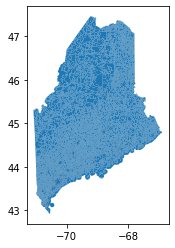

In [9]:
census_block_gdf.plot()

In [10]:
census_block_gdf.head()

,OBJECTID,GEOID10,STATEFP10,COUNTY,COUNTYFP10,COUSUB10,COUSUB10NA,TRACT10,BLOCK10,BLKGRP10,...,HSDSTRCT03,SNDSTRCT03,GlobalID,CreationDate,Creator,EditDate,Editor,Shape__Area,Shape__Length,geometry
0,1,230010206002074,23,Androscoggin,001,38740,Lewiston city,020600,2074,2,...,104,17,a7ab357d-3f7e-4f45-84d2-353958908c6f,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,3.044727e+04,1001.133941,"POLYGON ((-70.14052 44.03076, -70.14080 44.029..."
1,2,230010206002051,23,Androscoggin,001,38740,Lewiston city,020600,2051,2,...,70,16,91095d4f-608e-45e6-8b0f-f4832aef34cf,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2.912599e+04,1104.980015,"POLYGON ((-70.20198 44.06286, -70.20201 44.064..."
2,3,230010204001006,23,Androscoggin,001,38740,Lewiston city,020400,1006,1,...,72,16,178ee3f6-1103-49be-9d06-adcd88a6db2d,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,1.992767e+04,687.762904,"POLYGON ((-70.20420 44.09565, -70.20420 44.095..."
3,4,230010302001000,23,Androscoggin,001,40035,Lisbon town,030200,1000,1,...,104,17,2414ab17-b66a-4118-ae2e-cf76e69d6651,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2.201480e+06,5968.244918,"POLYGON ((-70.04943 44.01358, -70.04975 44.013..."
4,5,230010302001028,23,Androscoggin,001,40035,Lisbon town,030200,1028,1,...,105,17,5364de6c-e1df-41f7-8d9e-77dcd9a75b0d,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,2021-06-11T15:14:41.464001+00:00,bob.bistrais@maine.gov_maine,6.427181e+04,1839.514337,"POLYGON ((-70.05103 43.99288, -70.05104 43.992..."


In [17]:
census_block_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69518 entries, 0 to 69517
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       69518 non-null  int64   
 1   GEOID10        69518 non-null  object  
 2   STATEFP10      69518 non-null  object  
 3   COUNTY         69518 non-null  object  
 4   COUNTYFP10     69518 non-null  object  
 5   COUSUB10       69490 non-null  object  
 6   COUSUB10NA     69490 non-null  object  
 7   TRACT10        69518 non-null  object  
 8   BLOCK10        69518 non-null  object  
 9   BLKGRP10       69518 non-null  object  
 10  BLKNAME        69518 non-null  object  
 11  ALAND10        69518 non-null  int64   
 12  AWATER10       69518 non-null  int64   
 13  POP10          69518 non-null  int64   
 14  USDSTRCT03     67552 non-null  object  
 15  HSDSTRCT03     67552 non-null  object  
 16  SNDSTRCT03     67552 non-null  object  
 17  GlobalID       69518 no

In [18]:
census_block_gdf['GEOID'] = census_block_gdf['GEOID10'] 
census_block_gdf['GEOID'] = census_block_gdf['GEOID'].apply(lambda x: int(x))

In [11]:
census_block_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
census_block_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69518 entries, 0 to 69517
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBJECTID          69518 non-null  int64  
 1   GEOID             69518 non-null  int64  
 2   STATE             0 non-null      float64
 3   COUNTY            69518 non-null  int64  
 4   TRACT             69518 non-null  int64  
 5   BLOCK             69518 non-null  int64  
 6   BLKGRP            69518 non-null  int64  
 7   POP2010           69518 non-null  int64  
 8   HISPANIC          69518 non-null  int64  
 9   WHITE             69518 non-null  int64  
 10  BLACK             69518 non-null  int64  
 11  AMERI_AN          69518 non-null  int64  
 12  ASIAN             69518 non-null  int64  
 13  HAWN_PI           69518 non-null  int64  
 14  OTHER             69518 non-null  int64  
 15  MULTI_RACE        69518 non-null  int64  
 16  TOT_HU_OCCUPANCY  69518 non-null  int64 

In [12]:
census_block_df.head()

,OBJECTID,GEOID,STATE,COUNTY,TRACT,BLOCK,BLKGRP,POP2010,HISPANIC,WHITE,...,OTHER,MULTI_RACE,TOT_HU_OCCUPANCY,HU_OCCUPIED,HU_VACANT,GlobalID,CreationDate,Creator,EditDate,Editor
0,1,230010102003045,NaN,1,10200,3045,3,21,0,21,...,0,0,10,10,0,1e608e59-c974-42af-81a7-e2e4419e7179,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
1,2,230010102003046,NaN,1,10200,3046,3,16,0,16,...,0,0,10,9,1,be72d534-f52d-407d-8dbd-f8d009e2429b,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
2,3,230010102003047,NaN,1,10200,3047,3,73,0,73,...,0,0,35,30,5,217ea194-d5bf-4248-a1f9-861f48373231,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
3,4,230010102003048,NaN,1,10200,3048,3,0,0,0,...,0,0,0,0,0,f1ea6850-44a1-4827-bda6-f29fb860d6c4,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
4,5,230010102003049,NaN,1,10200,3049,3,14,0,14,...,0,0,8,8,0,7e3cf0c3-b6b1-4ee7-b867-a7d6bb7f1460,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine


In [19]:
maine_geo_demo_gdf = census_block_gdf.merge(census_block_df, on='GEOID')

In [20]:
maine_geo_demo_gdf.head()

,OBJECTID_x,GEOID10,STATEFP10,COUNTY_x,COUNTYFP10,COUSUB10,COUSUB10NA,TRACT10,BLOCK10,BLKGRP10,...,OTHER,MULTI_RACE,TOT_HU_OCCUPANCY,HU_OCCUPIED,HU_VACANT,GlobalID_y,CreationDate_y,Creator_y,EditDate_y,Editor_y
0,1,230010206002074,23,Androscoggin,001,38740,Lewiston city,020600,2074,2,...,0,0,1,1,0,00f33c1f-7782-4eb4-8b88-9b0a6bef4a06,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
1,2,230010206002051,23,Androscoggin,001,38740,Lewiston city,020600,2051,2,...,0,0,0,0,0,f364d330-8f37-451f-95a5-d56780a73394,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
2,3,230010204001006,23,Androscoggin,001,38740,Lewiston city,020400,1006,1,...,0,0,0,0,0,93fded1c-1b74-4e07-bfe2-fbcf815d94a1,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
3,4,230010302001000,23,Androscoggin,001,40035,Lisbon town,030200,1000,1,...,0,4,120,116,4,82100b66-7d54-47cd-adfc-239e970549e0,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine
4,5,230010302001028,23,Androscoggin,001,40035,Lisbon town,030200,1028,1,...,0,0,5,2,3,ecca0325-4aa7-4ced-9233-3827cce3675a,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine,2021/06/11 15:18:32.670+00,bob.bistrais@maine.gov_maine


In [44]:
len(maine_geo_demo_gdf)

69518

In [45]:
len(smelly_gdf)

2612

In [266]:
maine_stinky_joined = maine_geo_demo_gdf.sjoin(smelly_gdf, how='left')

/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [275]:
xmin, ymin, xmax, ymax = aoi_df.total_bounds
xmin, ymin, xmax, ymax

(-70.3619384765625, 43.59680319379521, -70.1751708984375, 43.70362249839005)

In [278]:
portland_stinky = maine_stinky_joined.cx[xmin:xmax, ymin:ymax]
portland_stinky.fillna(0, inplace=True)

/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [279]:
portland_stinky.head()

,OBJECTID_x,GEOID10,STATEFP10,COUNTY_x,COUNTYFP10,COUSUB10,COUSUB10NA,TRACT10,BLOCK10,BLKGRP10,...,index_right,epoch time,date & time,smell value,skewed latitude,skewed longitude,zipcode,smell description,symptoms,additional comments
10047,10048,230050010002000,23,Cumberland,005,60545,Portland city,001000,2000,2,...,0.0,0.000000e+00,0,0.0,0.0000,0.0000,0.0,0,0,0
10048,10049,230050006001029,23,Cumberland,005,60545,Portland city,000600,1029,1,...,0.0,0.000000e+00,0,0.0,0.0000,0.0000,0.0,0,0,0
10049,10050,230050012002000,23,Cumberland,005,60545,Portland city,001200,2000,2,...,1899.0,1.612225e+09,02/01/2021 19:10:34 -05:00,2.0,43.6507,-70.2670,4102.0,0,0,0
10049,10050,230050012002000,23,Cumberland,005,60545,Portland city,001200,2000,2,...,1674.0,1.604785e+09,11/07/2020 16:32:14 -05:00,4.0,43.6509,-70.2684,4102.0,Woodsmoke or petrochemical,Stinks!,0
10050,10051,230050011002004,23,Cumberland,005,60545,Portland city,001100,2004,2,...,0.0,0.000000e+00,0,0.0,0.0000,0.0000,0.0,0,0,0


In [280]:
len(portland_stinky)

4644

In [281]:
portland_stinky.columns

Index(['OBJECTID_x', 'GEOID10', 'STATEFP10', 'COUNTY_x', 'COUNTYFP10',
       'COUSUB10', 'COUSUB10NA', 'TRACT10', 'BLOCK10', 'BLKGRP10', 'BLKNAME',
       'ALAND10', 'AWATER10', 'POP10', 'USDSTRCT03', 'HSDSTRCT03',
       'SNDSTRCT03', 'GlobalID_x', 'CreationDate_x', 'Creator_x', 'EditDate_x',
       'Editor_x', 'Shape__Area', 'Shape__Length', 'geometry', 'GEOID',
       'OBJECTID_y', 'STATE', 'COUNTY_y', 'TRACT', 'BLOCK', 'BLKGRP',
       'POP2010', 'HISPANIC', 'WHITE', 'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI',
       'OTHER', 'MULTI_RACE', 'TOT_HU_OCCUPANCY', 'HU_OCCUPIED', 'HU_VACANT',
       'GlobalID_y', 'CreationDate_y', 'Creator_y', 'EditDate_y', 'Editor_y',
       'index_right', 'epoch time', 'date & time', 'smell value',
       'skewed latitude', 'skewed longitude', 'zipcode', 'smell description',
       'symptoms', 'additional comments'],
      dtype='object')

In [265]:
# fig, ax = plt.subplots(1,1)
# maine_stinky_joined.plot(
#     column='POP2010', 
#     ax=ax,
#     legend=True,
#     figsize=(20,20)
# )

In [283]:
portland_stinky.to_file('./data/portland_stinky.shp')

/tmp/ipykernel_31263/3527585330.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  portland_stinky.to_file('portland_stinky.shp')


In [413]:
portland_stinky_cleaned = gp.read_file('./data/portland_stinky_cleaned.shp')

In [414]:
portland_stinky_cleaned.head()

,OBJECTID_x,GEOID10,STATEFP10,COUNTY_x,COUNTYFP10,COUSUB10,COUSUB10NA,TRACT10,BLOCK10,BLKGRP10,...,epoch time,date & tim,smell valu,skewed lat,skewed lon,zipcode,smell desc,symptoms,additional,geometry
0,10048,230050010002000,23,Cumberland,005,60545,Portland city,001000,2000,2,...,0.000000e+00,0,0.0,0.0000,0.0000,0.0,0,0,0,"POLYGON ((-70.26726 43.65431, -70.26803 43.654..."
1,10049,230050006001029,23,Cumberland,005,60545,Portland city,000600,1029,1,...,0.000000e+00,0,0.0,0.0000,0.0000,0.0,0,0,0,"POLYGON ((-70.26453 43.65614, -70.26471 43.656..."
2,10050,230050012002000,23,Cumberland,005,60545,Portland city,001200,2000,2,...,1.612225e+09,02/01/2021 19:10:34 -05:00,2.0,43.6507,-70.2670,4102.0,0,0,0,"POLYGON ((-70.26821 43.65152, -70.26735 43.651..."
3,10050,230050012002000,23,Cumberland,005,60545,Portland city,001200,2000,2,...,1.604785e+09,11/07/2020 16:32:14 -05:00,4.0,43.6509,-70.2684,4102.0,Woodsmoke or petrochemical,Stinks!,0,"POLYGON ((-70.26821 43.65152, -70.26735 43.651..."
4,10051,230050011002004,23,Cumberland,005,60545,Portland city,001100,2004,2,...,0.000000e+00,0,0.0,0.0000,0.0000,0.0,0,0,0,"POLYGON ((-70.26445 43.65118, -70.26417 43.651..."


<AxesSubplot:>

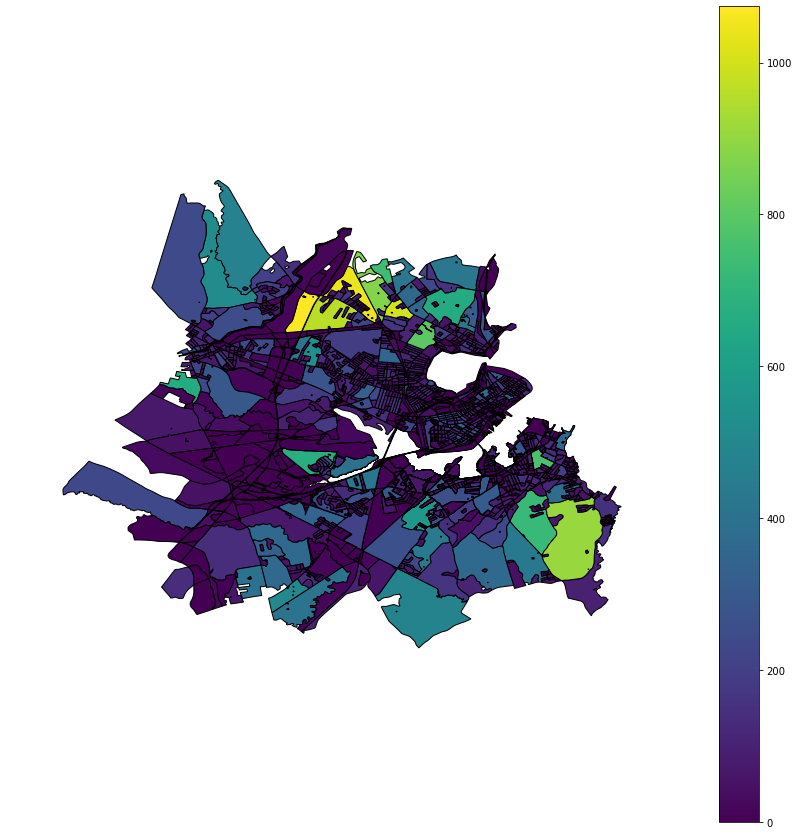

In [415]:
gplt.choropleth(portland_stinky_cleaned, hue='POP2010', figsize=(15,15), legend=True)

In [62]:
# ax = geoplot.kdeplot(
#     collisions.head(1000), clip=boroughs.geometry,
#     shade=True, cmap='Reds',
#     projection=geoplot.crs.AlbersEqualArea())
# geoplot.polyplot(boroughs, ax=ax, zorder=1)

In [245]:
# ax = gplt.kdeplot(
#     smelly_gdf, 
#     figsize=(12, 12),
#     cmap='Reds',
#     shade=True)
# gplt.polyplot(maine_stinky_joined, ax=ax, zorder=1)
# contextily.add_basemap(ax, crs=maine_stinky_joined.crs, source=contextily.providers.Stamen.TerrainBackground)

In [416]:
portland_stinky_cleaned.columns

Index(['OBJECTID_x', 'GEOID10', 'STATEFP10', 'COUNTY_x', 'COUNTYFP10',
       'COUSUB10', 'COUSUB10NA', 'TRACT10', 'BLOCK10', 'BLKGRP10', 'BLKNAME',
       'ALAND10', 'AWATER10', 'POP10', 'USDSTRCT03', 'HSDSTRCT03',
       'SNDSTRCT03', 'GlobalID_x', 'CreationDa', 'Creator_x', 'EditDate_x',
       'Editor_x', 'Shape__Are', 'Shape__Len', 'GEOID', 'OBJECTID_y', 'STATE',
       'COUNTY_y', 'TRACT', 'BLOCK', 'BLKGRP', 'POP2010', 'HISPANIC', 'WHITE',
       'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI', 'OTHER', 'MULTI_RACE',
       'TOT_HU_OCC', 'HU_OCCUPIE', 'HU_VACANT', 'GlobalID_y', 'Creation_1',
       'Creator_y', 'EditDate_y', 'Editor_y', 'index_righ', 'epoch time',
       'date & tim', 'smell valu', 'skewed lat', 'skewed lon', 'zipcode',
       'smell desc', 'symptoms', 'additional', 'geometry'],
      dtype='object')

In [417]:
portland_stinky_cleaned = portland_stinky_cleaned[
    ['GEOID10','TRACT10','BLOCK10','POP2010', 'HISPANIC', 'WHITE', 
     'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI','OTHER', 'MULTI_RACE',
    'TOT_HU_OCC', 'HU_OCCUPIE', 'HU_VACANT', 'smell valu','geometry']
]

In [291]:
# maine_stinky_filtered.head()

In [262]:
# for index, row in maine_stinky_filtered.iterrows():  
#     neighbors = maine_stinky_filtered[maine_stinky_filtered.geometry.touches(row['geometry'])].GEOID10.tolist() 
#     # neighbors = neighbors.remove(row.GEOID10)
#     maine_stinky_filtered.at[index, "my_neighbors"] = ", ".join(neighbors)

In [264]:
# maine_stinky_filtered.iloc[0]['my_neighbors']

In [263]:
# for index, row in maine_stinky_filtered.iterrows():  
#     neighbors = np.array(maine_stinky_filtered[maine_stinky_filtered.geometry.touches(row['geometry'])].GEOID10
#     #overlapping neighbors use if discrepances found with touches
#     overlap = np.array(neighbors[neighbors.geometry.overlaps(row['geometry'])].GEOID10)

#     neighbors = np.union1d(neighbors, overlap)

In [292]:
# maine_stinky_filtered.drop_duplicates(inplace=True)

In [293]:
# mask = maine_stinky_filtered['my_neighbors'].str.len() > 0

In [294]:
# maine_stinky_filtered.loc[mask]

/tmp/ipykernel_31263/2789552481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  portland_stinky_cleaned.centroid.plot(ax=ax, c='red')


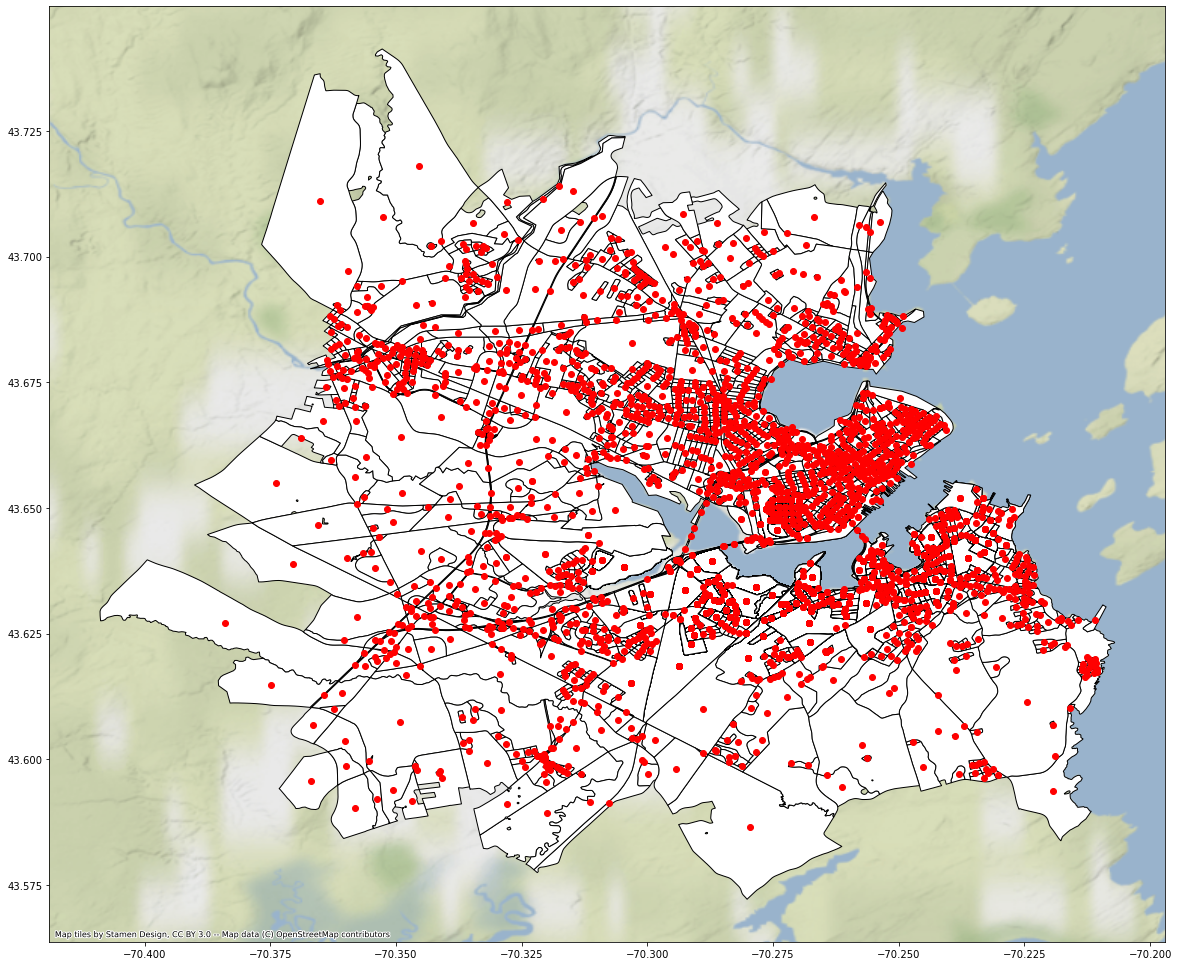

In [295]:
fig, ax = plt.subplots(figsize=(20,20))
portland_stinky_cleaned.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
portland_stinky_cleaned.centroid.plot(ax=ax, c='red')
contextily.add_basemap(ax, crs=portland_stinky_cleaned.crs, source=contextily.providers.Stamen.TerrainBackground)

In [418]:
portland_stinky_cleaned['center'] = portland_stinky_cleaned.centroid

/tmp/ipykernel_31263/3742815539.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  portland_stinky_cleaned['center'] = portland_stinky_cleaned.centroid
/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [419]:
portland_stinky_cleaned.rename(
    columns={
        'smell valu': 'smell value',
        'TOT_HU_OCC': 'TOT_HU_OCCUPANCY', 
        'HU_OCCUPIE': 'HU_OCCUPIED'
    }, inplace=True
)

/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [420]:
portland_stinky_cleaned.columns

Index(['GEOID10', 'TRACT10', 'BLOCK10', 'POP2010', 'HISPANIC', 'WHITE',
       'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI', 'OTHER', 'MULTI_RACE',
       'TOT_HU_OCCUPANCY', 'HU_OCCUPIED', 'HU_VACANT', 'smell value',
       'geometry', 'center'],
      dtype='object')

In [421]:
portland_stinky_geo = portland_stinky_cleaned[['GEOID10','center','geometry']].drop_duplicates().set_index('GEOID10')

In [422]:
portland_stinky_geo.head()

,center,geometry
GEOID10,,
230050010002000,POINT (-70.26868 43.65463),"POLYGON ((-70.26726 43.65431, -70.26803 43.654..."
230050006001029,POINT (-70.26570 43.65669),"POLYGON ((-70.26453 43.65614, -70.26471 43.656..."
230050012002000,POINT (-70.26726 43.65039),"POLYGON ((-70.26821 43.65152, -70.26735 43.651..."
230050011002004,POINT (-70.26377 43.65075),"POLYGON ((-70.26445 43.65118, -70.26417 43.651..."
230050011002005,POINT (-70.26516 43.64930),"POLYGON ((-70.26406 43.64934, -70.26429 43.649..."


In [423]:
portland_stinky_geo.iloc[0]['center'].x, portland_stinky_geo.iloc[0]['center'].y

(-70.26868263914714, 43.654625801739)

In [424]:
smelly_sum = portland_stinky_cleaned.groupby(
    by=['GEOID10','TRACT10','BLOCK10','POP2010', 'HISPANIC', 'WHITE', 
     'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI','OTHER', 'MULTI_RACE', 
     'TOT_HU_OCCUPANCY', 'HU_OCCUPIED', 'HU_VACANT']).agg('sum')
smelly_sum

,,,,,,,,,,,,,,,smell value
GEOID10,TRACT10,BLOCK10,POP2010,HISPANIC,WHITE,BLACK,AMERI_AN,ASIAN,HAWN_PI,OTHER,MULTI_RACE,TOT_HU_OCCUPANCY,HU_OCCUPIED,HU_VACANT,
230050001001002,000100,1002,0,0,0,0,0,0,0,0,0,0,0,0,0.0
230050001001003,000100,1003,0,0,0,0,0,0,0,0,0,0,0,0,0.0
230050001001004,000100,1004,84,0,80,0,1,0,0,0,3,70,58,12,0.0
230050001001005,000100,1005,63,0,60,0,0,1,0,0,2,55,48,7,0.0
230050001001006,000100,1006,67,0,58,2,0,2,0,0,5,36,34,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230050173032048,017303,2048,4,0,4,0,0,0,0,0,0,3,3,0,0.0
230050173032049,017303,2049,19,0,19,0,0,0,0,0,0,13,12,1,0.0
230050173032050,017303,2050,0,0,0,0,0,0,0,0,0,2,0,2,0.0


In [425]:
len(portland_stinky_cleaned['GEOID10'].unique())

2246

In [426]:
smelly_count = portland_stinky_cleaned.groupby(
    by=['GEOID10','TRACT10','BLOCK10','POP2010', 'HISPANIC', 'WHITE', 
     'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI','OTHER', 'MULTI_RACE', 
     'TOT_HU_OCCUPANCY', 'HU_OCCUPIED', 'HU_VACANT']).agg('count')
smelly_count

,,,,,,,,,,,,,,,smell value,geometry,center
GEOID10,TRACT10,BLOCK10,POP2010,HISPANIC,WHITE,BLACK,AMERI_AN,ASIAN,HAWN_PI,OTHER,MULTI_RACE,TOT_HU_OCCUPANCY,HU_OCCUPIED,HU_VACANT,,,
230050001001002,000100,1002,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
230050001001003,000100,1003,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
230050001001004,000100,1004,84,0,80,0,1,0,0,0,3,70,58,12,1,1,1
230050001001005,000100,1005,63,0,60,0,0,1,0,0,2,55,48,7,1,1,1
230050001001006,000100,1006,67,0,58,2,0,2,0,0,5,36,34,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230050173032048,017303,2048,4,0,4,0,0,0,0,0,0,3,3,0,1,1,1
230050173032049,017303,2049,19,0,19,0,0,0,0,0,0,13,12,1,1,1,1
230050173032050,017303,2050,0,0,0,0,0,0,0,0,0,2,0,2,1,1,1


In [427]:
smelly_mean = portland_stinky_cleaned.groupby(
    by=['GEOID10','TRACT10','BLOCK10','POP2010', 'HISPANIC', 'WHITE', 
     'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI','OTHER', 'MULTI_RACE', 
     'TOT_HU_OCCUPANCY', 'HU_OCCUPIED', 'HU_VACANT']).agg('mean')
smelly_mean

,,,,,,,,,,,,,,,smell value
GEOID10,TRACT10,BLOCK10,POP2010,HISPANIC,WHITE,BLACK,AMERI_AN,ASIAN,HAWN_PI,OTHER,MULTI_RACE,TOT_HU_OCCUPANCY,HU_OCCUPIED,HU_VACANT,
230050001001002,000100,1002,0,0,0,0,0,0,0,0,0,0,0,0,0.0
230050001001003,000100,1003,0,0,0,0,0,0,0,0,0,0,0,0,0.0
230050001001004,000100,1004,84,0,80,0,1,0,0,0,3,70,58,12,0.0
230050001001005,000100,1005,63,0,60,0,0,1,0,0,2,55,48,7,0.0
230050001001006,000100,1006,67,0,58,2,0,2,0,0,5,36,34,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230050173032048,017303,2048,4,0,4,0,0,0,0,0,0,3,3,0,0.0
230050173032049,017303,2049,19,0,19,0,0,0,0,0,0,13,12,1,0.0
230050173032050,017303,2050,0,0,0,0,0,0,0,0,0,2,0,2,0.0


In [472]:
# smelly_agg = smelly_count.drop(['center','geometry'], axis=1).merge(portland_stinky_geo, left_index=True, right_index=True)
smelly_agg = smelly_mean.merge(portland_stinky_geo, left_index=True, right_index=True)

In [473]:
smelly_agg['X'] = smelly_agg['center'].apply(lambda x: x.x)
smelly_agg['Y'] = smelly_agg['center'].apply(lambda x: x.y)

In [474]:
smelly_agg.reset_index(inplace=True)

In [475]:
smelly_agg.head()

,GEOID10,TRACT10,BLOCK10,POP2010,HISPANIC,WHITE,BLACK,AMERI_AN,ASIAN,HAWN_PI,OTHER,MULTI_RACE,TOT_HU_OCCUPANCY,HU_OCCUPIED,HU_VACANT,smell value,center,geometry,X,Y
0,230050001001002,000100,1002,0,0,0,0,0,0,0,0,0,0,0,0,0.0,POINT (-70.24975 43.67187),"POLYGON ((-70.24424 43.66890, -70.24493 43.669...",-70.249749,43.671869
1,230050001001003,000100,1003,0,0,0,0,0,0,0,0,0,0,0,0,0.0,POINT (-70.25525 43.67249),"POLYGON ((-70.25505 43.67255, -70.25521 43.672...",-70.255247,43.672493
2,230050001001004,000100,1004,84,0,80,0,1,0,0,0,3,70,58,12,0.0,POINT (-70.24522 43.66899),"POLYGON ((-70.24602 43.66923, -70.24593 43.669...",-70.245216,43.668986
3,230050001001005,000100,1005,63,0,60,0,0,1,0,0,2,55,48,7,0.0,POINT (-70.24671 43.66933),"POLYGON ((-70.24602 43.66923, -70.24620 43.669...",-70.246708,43.669329
4,230050001001006,000100,1006,67,0,58,2,0,2,0,0,5,36,34,2,0.0,POINT (-70.24760 43.66863),"POLYGON ((-70.24744 43.66807, -70.24823 43.668...",-70.247600,43.668631


<AxesSubplot:>

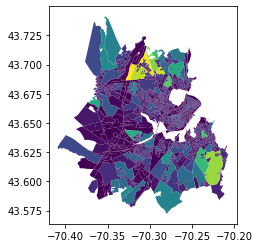

In [458]:
smelly_agg.plot(column='POP2010')

In [398]:
smelly_agg.columns

Index(['GEOID10', 'TRACT10', 'BLOCK10', 'POP2010', 'HISPANIC', 'WHITE',
       'BLACK', 'AMERI_AN', 'ASIAN', 'HAWN_PI', 'OTHER', 'MULTI_RACE',
       'TOT_HU_OCCPANCY', 'HU_OCCUPIED', 'HU_VACANT', 'smell value', 'center',
       'geometry', 'X', 'Y'],
      dtype='object')

In [399]:
# for index, row in smelly_agg.iterrows():  
#     neighbors = smelly_agg[smelly_agg.geometry.touches(row['geometry'])].GEOID10.tolist() 
#     # neighbors = neighbors.remove(row.GEOID10)
#     smelly_agg.at[index, "neighbors"] = ", ".join(neighbors)

In [400]:
# smelly_agg[smelly_agg['neighbors'].str.len() > 0]

In [401]:
# smelly_with_neighbors = smelly_agg[smelly_agg['neighbors'].str.len() > 0]

In [402]:
# smelly_with_neighbors.drop(['center','neighbors'], axis=1).to_file('./data/smelly_neighbors_sum.shp')

In [403]:
# smelly_with_neighbors.crs

/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


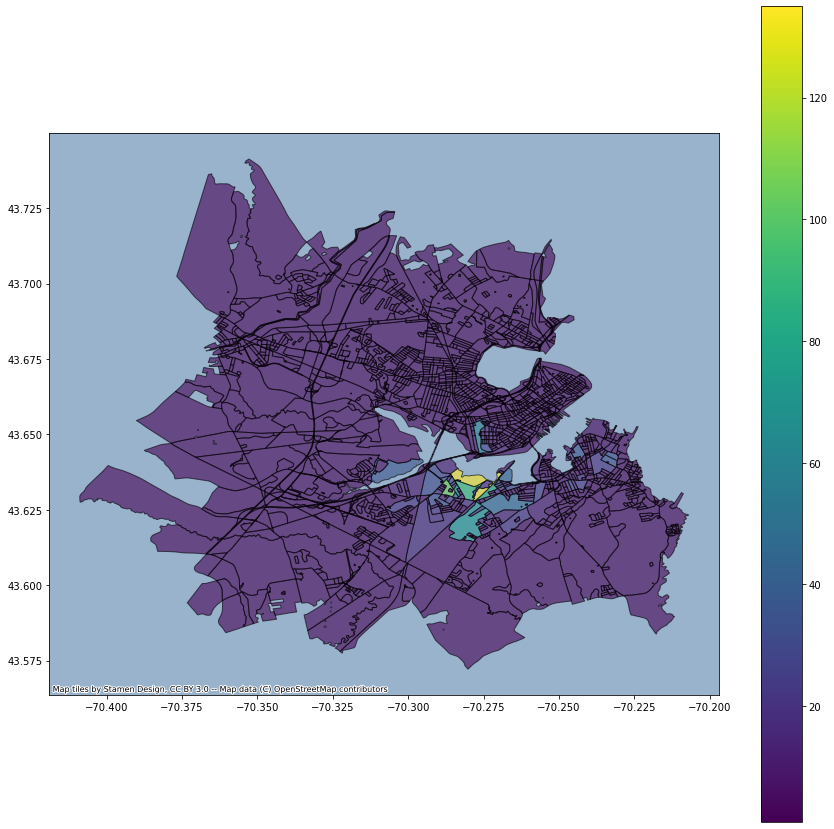

In [470]:
fig, ax = plt.subplots(figsize=(15,15))
smelly_agg.plot(column='smell value', ax=ax, **{'edgecolor':'black', 'facecolor':'white'}, alpha=0.6, legend=True)
# smelly_with_neighbors.drop(['center','neighbors'], axis=1).centroid.plot(ax=ax, c='red')
contextily.add_basemap(ax, crs=smelly_agg.crs)

In [433]:
# smelly_agg.rename(columns={'TOT_HU_OCC': 'TOT_HU_OCCUPANCY', 'HU_OCCUPIE': 'HU_OCCUPIED', 'smell valu': 'smell value'}, inplace=True)

In [434]:
model_cols = ['POP2010', 'HISPANIC', 'WHITE', 'BLACK', 
     'AMERI_AN', 'ASIAN', 'HAWN_PI','OTHER', 'MULTI_RACE', 
     'TOT_HU_OCCUPANCY', 'HU_OCCUPIED', 'HU_VACANT']

In [435]:
smelly_agg[model_cols] = smelly_agg[model_cols].astype('float')

In [325]:
# X_stack = []
# for col in model_cols:
#     col_arr = smelly_agg[col].values.reshape((-1,1))
#     X_stack.append(col_arr)
# X = np.hstack(X_stack)

In [326]:
# X.shape

In [327]:
# y = smelly_agg['smell value'].values.reshape((-1, 1))

In [328]:
# coords = list(zip(smelly_agg['X'].values, smelly_agg['Y'].values))

In [222]:
# model = GWR(coords, y, X, bw=90.000, fixed=False, kernel='bisquare')
# results = model.fit()
# print(results.params.shape)

In [436]:
g_y = smelly_agg['smell value'].values.reshape((-1,1))
g_X = smelly_agg[model_cols].values
u = smelly_agg['X']
v = smelly_agg['Y']
g_coords = list(zip(u,v))

In [437]:
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

In [438]:
g_y = g_y.reshape((-1,1))

In [439]:
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [440]:
smelly_agg['smell value'].values.reshape((-1,1)).shape

(2246, 1)

In [441]:
g_y.shape

(2246, 1)

In [442]:
g_y[0:5]

array([[-0.43394017],
       [-0.43394017],
       [-0.43394017],
       [-0.43394017],
       [-0.43394017]])

In [443]:
g_X.shape

(2246, 12)

In [444]:
g_X[0:5]

array([[-0.52189024, -0.32373354, -0.53621197, -0.16419458, -0.2357964 ,
        -0.27912583, -0.06225842, -0.13251547, -0.30553575, -0.52415661,
        -0.52300323, -0.38362933],
       [-0.52189024, -0.32373354, -0.53621197, -0.16419458, -0.2357964 ,
        -0.27912583, -0.06225842, -0.13251547, -0.30553575, -0.52415661,
        -0.52300323, -0.38362933],
       [ 0.38849588, -0.32373354,  0.49579993, -0.16419458,  1.21914514,
        -0.27912583, -0.06225842, -0.13251547,  0.59267537,  1.05987965,
         0.87529298,  2.74957602],
       [ 0.16089935, -0.32373354,  0.23779696, -0.16419458, -0.2357964 ,
        -0.11005447, -0.06225842, -0.13251547,  0.29327166,  0.72044331,
         0.63420743,  1.44407379],
       [ 0.20425107, -0.32373354,  0.21199666, -0.02573728, -0.2357964 ,
         0.0590169 , -0.06225842, -0.13251547,  1.19148278,  0.29049061,
         0.29668765,  0.13857156]])

In [445]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)

In [446]:
gwr_bw = gwr_selector.search(bw_min=2)
gwr_bw

/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.03063e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.26807e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.25333e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.62069e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/ying/anaconda3/envs/tf/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.61031e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home

LinAlgError: Matrix is singular.

In [448]:
# gamma_model = sm.GLM(g_y, g_X, family=sm.families.Gamma())

In [447]:
# gamma_results = gamma_model.fit()

In [167]:
# gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
# gwr_results

In [449]:
corr_cols = model_cols + ['smell value']

<AxesSubplot:>

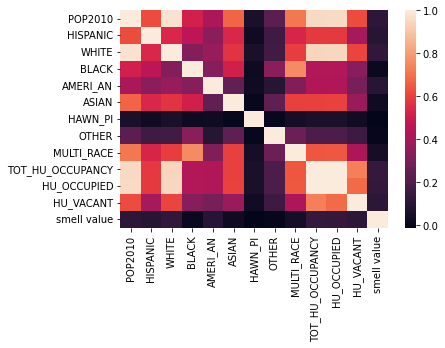

In [452]:
sns.heatmap(smelly_agg[corr_cols].corr())